In [1]:
from collections import defaultdict
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.externals import joblib
import gensim

c:\users\pranjal\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
c:\users\pranjal\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
BASE_PATH = "../data/"

In [3]:
def plot_random(test_features, y_true, test_features_transformed):
    mnb_clf = joblib.load('../model/mnb.pkl')
    rf_clf = joblib.load('../model/rf.pkl')
    adb_clf = joblib.load('../model/adb.pkl')
    svc_linear_clf = joblib.load('../model/svc_linear.pkl')
    svc_linear_glove_clf = joblib.load('../model/svc_glove_mean.pkl')
    y_proba_mnb = mnb_clf.predict_proba(test_features)[:, 1]
    y_proba_rf = rf_clf.predict_proba(test_features)[:, 1]
    y_proba_adb = adb_clf.predict_proba(test_features)[:, 1]
    y_proba_svc_linear = svc_linear_clf.predict_proba(test_features)[:, 1]
    y_proba_svc_glove = svc_linear_glove_clf.predict_proba(test_features_transformed)[:, 1]
    precision1, recall1, _ = precision_recall_curve(y_true, y_proba_mnb)
    precision2, recall2, _ = precision_recall_curve(y_true, y_proba_rf)
    precision3, recall3, _ = precision_recall_curve(y_true, y_proba_adb)
    precision4, recall4, _ = precision_recall_curve(y_true, y_proba_svc_linear)
    precision5, recall5, _ = precision_recall_curve(y_true, y_proba_svc_glove)
    plt.step(recall1, precision1, alpha=0.6, where='post', label="MNB")
    plt.step(recall2, precision2, alpha=0.6, where='post', label="RF")
    plt.step(recall3, precision3, alpha=0.6, where='post', label="ADB")
    plt.step(recall4, precision4, alpha=0.6, where='post', label="SVC_Linear")
    plt.step(recall5, precision5, alpha=0.6, where='post', label="SVC_Linear_Glove")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid()
    plt.legend()
    plt.title('2-class Precision-Recall curve')
    plt.show()

In [4]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        final_res = []
        for words in X:
            tmp_list = []
            for w in words:
                try:
                    tmp_list.append(self.word2vec[w])
                except KeyError:
                    tmp_list.append(np.zeros(self.dim))
            final_res.append(np.mean(tmp_list, axis=0))
        return np.array(final_res)            
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [19]:
class AverageEmbeddingVectorizer(object):
    def __init__(self, glove2vec, word2vec):
        self.glove2vec = glove2vec
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        final_res = []
        for words in X:
            tmp_list = []
            for w in words:
                try:
                    w2v_list = self.word2vec[w]
                except KeyError:
                    w2v_list = np.zeros(self.dim)
                try:
                    g2v_list = self.glove2vec[w]
                except KeyError:
                    g2v_list = np.zeros(self.dim)
                tmp_list.append(np.concatenate([g2v_list, w2v_list]))
            final_res.append(np.mean(tmp_list, axis=0))
        return np.array(final_res)            
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [5]:
def remove_hyperlink(text):
    text = re.sub(r"http\S+", '',  text.decode("utf-8"))
    return text


def read_files(file_type):
    x_list = []
    y_list = []
    with open(BASE_PATH + file_type + "_x.txt", "rb") as f:
        for line in f:
            processed_line = remove_hyperlink(line)
            x_list.append(processed_line.strip())

    with open(BASE_PATH + file_type + "_y.txt", "rb") as f:
        for line in f:
            y_list.append(int(line.strip()))

    return x_list, y_list

In [6]:
def plot_pr_curve(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.step(recall, precision, color='r', alpha=0.2,
             where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.grid()
    plt.show()

In [7]:
def evaluate(model, test_features, y_true):
    y_pred = model.predict(test_features)
    y_proba = model.predict_proba(test_features)[:, 1]
    accuracy = accuracy_score(y_true, y_pred) * 100.0
    auc_score = metrics.roc_auc_score(y_true, y_proba)
    precision_score = metrics.average_precision_score(y_true, y_proba)
    plot_pr_curve(y_true, y_proba)
    return round(accuracy,2), round(auc_score, 4), round(precision_score, 4)

In [8]:
def load_glove():
    w2v = {}
    with open(BASE_PATH + "glove.6B.300d.txt", "rb") as lines:
        for line in lines:
            tmp = line.split()
            word = tmp[0].decode('utf-8')
            embedding = np.array([float(val) for val in tmp[1:]])
            w2v[word] = embedding
    return w2v

In [9]:
def load_word2vec():
    model = gensim.models.KeyedVectors.load_word2vec_format(BASE_PATH + 'GoogleNews-vectors-negative300.bin.gz', \
                                                      binary=True)
    return model

In [20]:
x_train, y_train = read_files("train")
print("Training File Read - Size: ", len(x_train))
x_test, y_test = read_files("test")
print("Test File Read - Size: ", len(x_test))
x_val, y_val = read_files("val")
print("Validation File Read - Size: ", len(x_val))

Training File Read - Size:  2594
Test File Read - Size:  721
Validation File Read - Size:  289


In [11]:
g2v = load_glove()
w2v = load_word2vec()

In [21]:
x_train_tf_idf_new = AverageEmbeddingVectorizer(g2v, w2v).fit_transform(x_train)
x_test_tf_idf_new = AverageEmbeddingVectorizer(g2v, w2v).fit_transform(x_test)

In [25]:
svm_clf = SVC(probability=True, kernel='linear').fit(x_train_tf_idf_new, y_train)
#joblib.dump(svm_clf, '../model/svc_g2v_w2v_mean.pkl')

['../model/svc_g2v_w2v_mean.pkl']

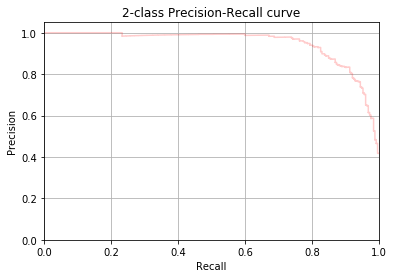

Linear SVM Metrics: Accuracy-91.4, AUC-0.9648 and PR_Score-0.9491


In [24]:
#svc_linear_glove_clf = joblib.load('../model/svc_word2vec_mean.pkl')
accuracy, auc_score, precision_score = evaluate(svm_clf, x_test_tf_idf_new, y_test)
print("Linear SVM Metrics: Accuracy-{accuracy}, AUC-{auc_score} and PR_Score-{precision_score}"
      .format(accuracy=accuracy, auc_score=auc_score, precision_score=precision_score))
